In [2]:
%load_ext autoreload
%autoreload 2
from lib.preamble import *
%matplotlib widget

# PL polarisation

In [3]:
paths = glob("../data/2024-01-23*/d*.h5")
paths = [p for p in paths if "Beamsplitter" not in p]
paths.sort()
paths

['../data/2024-01-23 CrPS4/d002_flake03_299K.h5',
 '../data/2024-01-23 CrPS4/d002_flake04_299K.h5',
 '../data/2024-01-23 CrPS4/d002_flake05_299K.h5',
 '../data/2024-01-23 CrPS4/d002_flake06_299K.h5',
 '../data/2024-01-23 CrPS4/d002_flake07_299K.h5',
 '../data/2024-01-23 CrPS4/d003_flake03_190K.h5',
 '../data/2024-01-23 CrPS4/d003_flake03_190K_light_on.h5',
 '../data/2024-01-23 CrPS4/d003_flake04_190K_light_on.h5',
 '../data/2024-01-23 CrPS4/d003_flake05_190K_light_on.h5',
 '../data/2024-01-23 CrPS4/d003_flake06_190K_light_on.h5',
 '../data/2024-01-23 CrPS4/d003_flake07_190K_light_on.h5',
 '../data/2024-01-23 CrPS4/d004_flake03_90K_light_on.h5',
 '../data/2024-01-23 CrPS4/d004_flake04_90K_light_on.h5',
 '../data/2024-01-23 CrPS4/d004_flake05_90K_light_on.h5',
 '../data/2024-01-23 CrPS4/d004_flake06_90K_light_on.h5',
 '../data/2024-01-23 CrPS4/d004_flake07_90K_light_on.h5',
 '../data/2024-01-23 CrPS4/d005_flake03_35K_light_on.h5',
 '../data/2024-01-23 CrPS4/d005_flake04_35K_light_on.h5',

In [4]:
def import_anisotropy(p):
	try:
		with h5py.File(p, "r") as f:
			wavelength = np.array(f['x'])[0]
			angle = np.array(f['y'])
			counts = np.array(f['z'])
	except:
		print(f"Error importing {p}")
		return None
	
	ar = xr.DataArray(
		counts,
		coords={
			'angle': angle,
			'wavelength': wavelength
		}
	)

	ar.attrs = {
		**ar.attrs,
		"path": p.split("data/")[-1],
		"name": ".".join(p.split("data/")[-1].split(".")[:-1]),
		"flake": "flake" + p.split("flake")[-1].split("_")[0],
		"temperature": float(p.split("K")[0].split("_")[-1]),
	}
	ar.name = ar.attrs["name"]
	
	return ar

data = [import_anisotropy(p) for p in paths]
data = [d for d in data if d is not None]

Error importing ../data/2024-01-23 CrPS4/d003_flake03_190K.h5


/home/leon/Projekte/batchelorarbeit/src/lib/utils.py:7: RuntimeWarning: divide by zero encountered in divide
  return 1239.84193/ev
/home/leon/Projekte/batchelorarbeit/src/lib/utils.py:7: RuntimeWarning: divide by zero encountered in divide
  return 1239.84193/ev


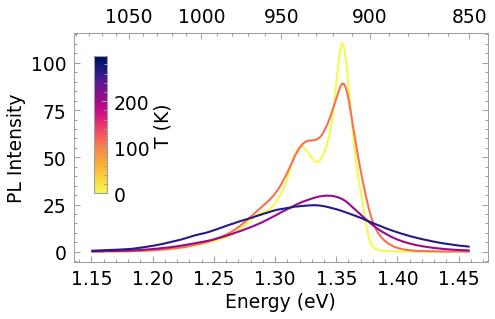

In [11]:
sel = [d for d in data if "flake03" in d.name]

assert len(sel)>1

temperatures = [d.attrs["temperature"] for d in sel]

sel = sorted(sel, key=lambda x: x.attrs["temperature"])

color = cm["CET_L8"](temperatures / np.max(temperatures))

plt.figure(figsize=FIGSIZE_MEDIUM)
ax = plt.gca()
for d,c in zip(sel, color):
    d = d.mean("angle")
    d = d - d.sel(wavelength=slice(550, 600)).mean()
    # d = d / d.sel(wavelength=slice(800, 820)).max() 
    d = d / d.sel(wavelength=slice(680, 685)).mean() 
    d = d.sel(wavelength=slice(850, 1100))
    d = d.assign_coords(energy=ev_to_nm(d.wavelength))
    # d = d/d.max()
    d.plot(x="energy", c=c, _labels=False)

plot.energy_ticks(locator=False)

plt.xlabel(r"Energy (eV)")
plt.ylabel(r"PL Intensity")

# add colorbar with field
sm = plt.cm.ScalarMappable(cmap=cm["CET_L8_r"], norm=plt.Normalize(vmax=0, vmin=np.max(temperatures)))
sm.set_array([])
# insert axs for colorbar into axs[-1]
cax = plt.gca().inset_axes([0.05, 0.3, 0.03, 0.6])
plt.colorbar(sm, cax=cax, label=r"T (K)")

plt.tight_layout()  
plt.savefig("../report/figures/2024-04-22 CrPS4 temperature series.pdf")

plt.show()

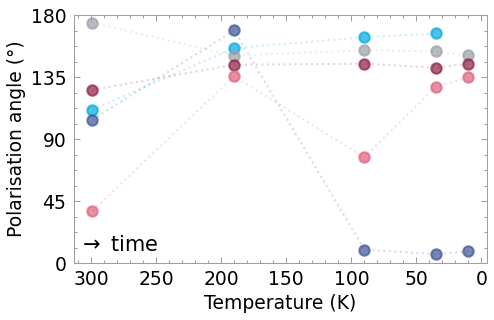

CPU times: user 400 ms, sys: 245 ms, total: 645 ms
Wall time: 340 ms


In [52]:

%%time
from sklearn.linear_model import HuberRegressor, LinearRegression

def polarisation_model(x, a,b,c):  return a* np.cos(x*np.pi/180) + b* np.sin(x*np.pi/180) + c
def polarisation_fit(angle, values, linear_drift=True):
    reg = HuberRegressor()
    # reg = LinearRegression()
    x = np.cos(angle*np.pi/180*2)   # 2x angle because of the cos^2
    y = np.sin(angle*np.pi/180*2)   # 2x angle because of the cos^2
    if linear_drift:
        z = np.arange(len(angle))   # linear drift
        X = np.column_stack((x, y, z))
    else:
        X = np.column_stack((x, y,))
    reg.fit(X, values)
    (a,b), c = reg.coef_[:2], reg.intercept_
    return (a,b,c), reg
def polarisation_lin(angle, values):
    (a,b,c), reg = polarisation_fit(angle, values)
    angle = np.arctan2(b,a) * 180 / np.pi
    angle = angle/2 # because of the cos^2
    angle = angle % 180
    return 0, angle , 0

def pre(d): return d.sel(wavelength=slice(820, 1000)).rolling(wavelength=50).mean().max("wavelength")
# def pre(d): return d.sel(wavelength=slice(850, 1000)).mean("wavelength")

def get_polarisation(d):
    sel = pre(d)
    _, angle, _ = polarisation_lin(sel.angle*2, sel)    
    return angle

groups = list(groupby_list(data, lambda d: d.attrs["flake"]).items())[1:]

fit_data = {k:  np.array([[d.temperature, get_polarisation(d)] for d in v]).T for k,v in groups}

plt.figure(figsize=FIGSIZE_MEDIUM)
for k,v in fit_data.items():
    mk = plt.plot(v[0], v[1], "o", ms=5, label=k, alpha=.7)
    plt.plot(v[0], v[1], linestyle="dotted", color=mk[0].get_color(), alpha=.2)
# plt.legend(fontsize=FONTSIZE_TINY, frameon=True, loc="right")
plt.gca().invert_xaxis()
plt.ylim(0, 180)
plt.yticks(np.arange(0, 181, 45))
plt.text(0.01, 0.05, r"$\rightarrow$ time",transform=plt.gca().transAxes)
plt.xlabel("Temperature (K)")
plt.ylabel("Polarisation angle (°)")
plt.show()

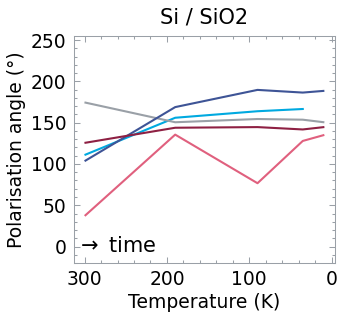

In [53]:
def warp(a):
    center = 120
    return (a - center + 90) % 180 - 90 + center

plt.figure(figsize=(2.5,FIGSIZE_MEDIUM[1]))
for k,v in fit_data.items():
    a = v[1]
    a = warp(a)
    plt.plot(v[0], a, "-", label=k)
# plt.legend(fontsize=5, frameon=True, ncol=2, loc="lower right")
plt.gca().invert_xaxis()
# plt.ylim(0, 180)
# plt.yticks(np.arange(0, 361, 45))
plt.title("Si / SiO2")
plt.text(0.01, 0.05, r"$\rightarrow$ time",transform=plt.gca().transAxes)
plt.xlabel("Temperature (K)")
plt.ylabel("Polarisation angle (°)")

plt.ylim(-20, 255)
plt.savefig("../report/figures/2024-01-23 rotating pl.pdf")
plt.show()

In [27]:
FIGSIZE_SMALL

(2.5, 1.6666666666666667)

# Looking at Images

In [5]:
paths = glob("../data/2024-01-23*/*.bmp")

In [6]:
def import_image(p):
    img = xr.DataArray(mpl.image.imread(p), dims=["y", "x", "channel"])
    img.name = p
    img.attrs = {
        "flake": "flake" + p.split("flake")[-1].split("_")[0],
        "temperature": int(p.split("K")[0].split("_")[-1]),
    }
    return img

images = [import_image(p) for p in paths]

## Look at one flake

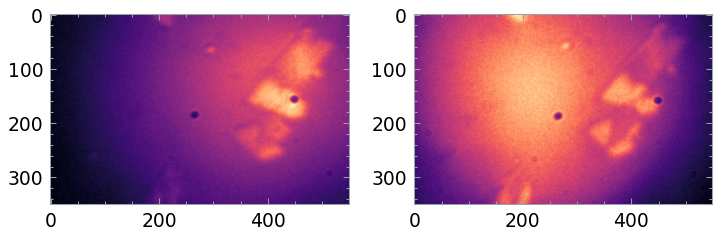

In [8]:
def cropp_image(image):
    cropped = image.sel(x=slice(600, 1150), y=slice(450, 800)).mean("channel")
    cropped.attrs = image.attrs
    return cropped
sel = [i for i in images if "flake04" in i.attrs["flake"]]
sel = sorted(sel, key=lambda i: i.attrs["temperature"])
sel = [sel[0], sel[-1]]
sel = [cropp_image(i) for i in sel]
plt.figure()
plt.subplot(121)
plt.imshow(sel[0])
plt.subplot(122)
plt.imshow(sel[1])

In [7]:
from skimage.filters import sobel, gaussian
def edge(image, sigma=10):
    g = gaussian(image, sigma)
    return sobel(g)**2/g

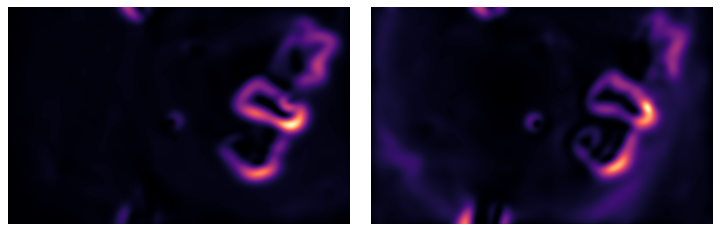

In [10]:
images_edge = [edge(i) for i in sel]

plt.figure()
plt.subplot(121)
plt.imshow(images_edge[0])
plt.subplot(122)
plt.imshow(images_edge[1])
for a in plt.gcf().axes: a.axis("off")

In [11]:
# correlation based alignment
from skimage.transform import warp, SimilarityTransform
from scipy.signal import correlate

corr = correlate(images_edge[0], images_edge[1], mode="full", method="fft")
shift = (np.array(corr.shape) // 2 - np.unravel_index(corr.argmax(), corr.shape))[::-1]


In [8]:
# align images in translation, scale and rotation
from skimage.transform import SimilarityTransform, warp
from scipy.optimize import minimize, basinhopping
from scipy.signal import correlate

def shift_correlation(img1, img2):
    corr = correlate(img1, img2, mode="full", method="fft")
    shift = (np.array(corr.shape) // 2 - np.unravel_index(corr.argmax(), corr.shape))[::-1]
    return shift

def mse(img1, img2):
    return np.mean((img1 - img2)**2)

def error(params, img1, img2):
    tform = SimilarityTransform(translation=params[:2], scale=params[2], rotation=params[3])
    img2 = warp(img2, tform)
    error = mse(img1, img2)
    error += (params[2] - 1)**2 * 100
    return error

def align(img1, img2):
    shift = shift_correlation(img1, img2)
    params = [shift[0], shift[1], 1, 0]
    res = minimize(error, params, args=(img1, img2), method="Nelder-Mead")
    # res = basinhopping(error, params, minimizer_kwargs={"args": (img1, img2)}, disp=True)
    params = res.x
    if not res.success:
        print("alignment failed")
        # raise Exception(res.message)
    return SimilarityTransform(translation=params[:2], scale=params[2], rotation=params[3])

def align_get_angle(img1, img2):
    edge = [edge(i) for i in [img1, img2]]
    return align(*edge).rotation * 180 / np.pi

[[ 9.99999639e-01 -8.84232990e-04 -1.64727898e+01]
 [ 8.84232990e-04  9.99999639e-01 -7.75167267e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[-16.47278977  -7.75167267] 1.0000000302568273 0.0008842330779925805


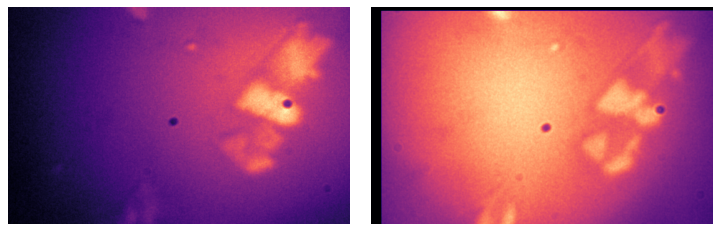

In [13]:
# trans = align(sel[0], sel[1])
trans = align(images_edge[0], images_edge[1])
print(trans.params)
print(trans.translation, trans.scale, trans.rotation)

plt.figure()
plt.subplot(121)
plt.imshow(sel[0])
plt.axis("off")
plt.subplot(122)
plt.imshow(warp(sel[1], trans))
plt.axis("off")
plt.show()

In [14]:
# make a overlay image
from copy import copy
from skimage.color import gray2rgb
from skimage.exposure import rescale_intensity, equalize_hist

def overlay(img1, img2, equalize=True):
    if equalize:
        img1 = equalize_hist(np.array(img1))
        img2 = equalize_hist(np.array(img2))
    else:
        img1 = rescale_intensity(np.array(img1))
        img2 = rescale_intensity(np.array(img2))
    img1 = gray2rgb(img1)
    img2 = gray2rgb(img2)
        
    c1 = np.array([1,0,1])
    c2 = np.array([0,1,0])
    
    img1 *= c1
    img2 *= c2    
    return img1 + img2

plt.imshow(overlay(sel[0], warp(sel[1],trans), equalize=False))
# plt.imshow(overlay(edge[0], warp(edge[1],trans), equalize=False))

## Look at all flakes

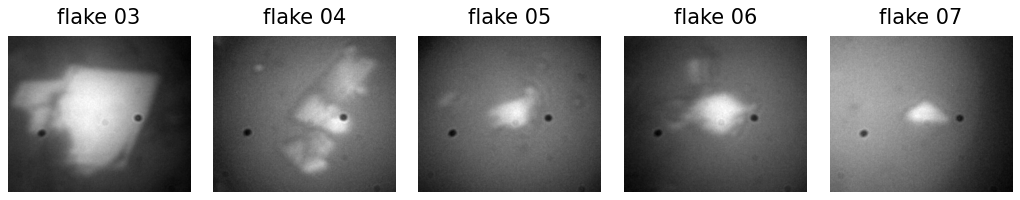

In [15]:
def cropp_image(image):
    cropped = image.sel(x=slice(800, 1150), y=slice(450, 750)).mean("channel")
    cropped.attrs = image.attrs
    return cropped

cropped_images = [cropp_image(i) for i in images]

groups_images = list(groupby_list(cropped_images, lambda d: d.attrs["flake"]).items())

# create previews of all flakes
fig, axs = plt.subplots(1,len(groups_images), figsize=FIGSIZE_WIDE, sharex=True, sharey=True)

def normalize(img):
    img = img - img.min()
    img = img / img.max()
    return img

for ax, (g, imgs) in zip(axs, groups_images):
    ax.imshow(normalize(imgs[-1]), cmap="gray")
    # ax.imshow(edge(imgs[-1]), cmap="gray")
    ax.axis("off")
    # ax.plot([0,1], [.5,.5], color="red", transform=ax.transAxes, alpha=.2)
    # ax.plot([.5,.5], [0,1], color="red", transform=ax.transAxes, alpha=.2)
    ax.set_title(g.replace("flake", "flake "))
    
plt.savefig("../report/figures/2024-01-23 flakes.pdf", bbox_inches="tight")
plt.show()

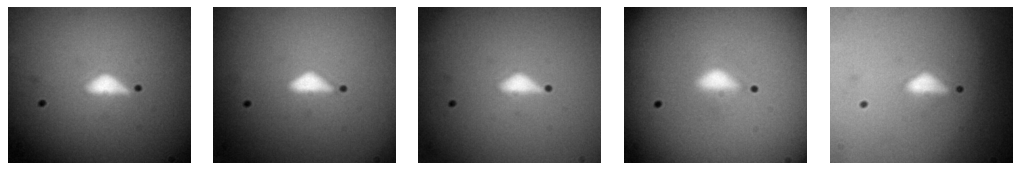

In [16]:
sel = groups_images[-1][1]

fig, axs = plt.subplots(1, len(sel), figsize=FIGSIZE_WIDE)
for a, s in zip(axs, sel):
    a.imshow(s, cmap="gray")
    # a.imshow(edge(s, 3), cmap="gray")
    a.axis("off")

In [17]:
%%time
angles_images = {}
for g, imgs in groups_images:
    imgs = list(sorted(imgs, key=lambda d: d.temperature, reverse=True))
    a = np.array([[i.temperature, align_get_angle(imgs[-1].data, i.data)] for i in imgs])
    angles[g] = a
    
    
plt.figure()
for g, a in angles.items():
    plt.plot(a[:,0], a[:,1], "o", label=g, ms=5, alpha=.7)
plt.ylim(-5, None)

plt.ylabel("rotation from start in degrees")
plt.legend(fontsize=FONTSIZE_TINY, frameon=True, loc="lower right")
plt.gca().invert_xaxis()
# plt.ylim(0, 180)
# plt.yticks(np.arange(0, 181, 45))
plt.text(0.01, 0.05, r"$\rightarrow$ time",transform=plt.gca().transAxes)
plt.savefig("../figures/2024-01-23 rotation images.png", dpi=300, bbox_inches="tight")
plt.show()

NameError: cannot access free variable 'edge' where it is not associated with a value in enclosing scope

In [18]:
{i: img.name for i, img in enumerate(images) if "flake05" in img.name}

{3: '../data/2024-01-23 CrPS4/flake05_rightSubstrate_299K.bmp',
 18: '../data/2024-01-23 CrPS4/flake05_rightSubstrate_10K.bmp',
 19: '../data/2024-01-23 CrPS4/flake05_rightSubstrate_35K.bmp',
 23: '../data/2024-01-23 CrPS4/flake05_rightSubstrate_90K.bmp',
 24: '../data/2024-01-23 CrPS4/flake05_rightSubstrate_190K.bmp'}

# Data from 2024-02-29

In [54]:
paths = glob("../data/2024-01-29*/d*.h5")
paths = [p for p in paths if "Beamsplitter" not in p]
paths.sort()
# paths

def import_anisotropy(p):
	try:
		with h5py.File(p, "r") as f:
			wavelength = np.array(f['x'])[0]
			angle = np.array(f['y'])
			counts = np.array(f['z'])
	except:
		print(f"Error importing {p}")
		return None
	
	ar = xr.DataArray(
		counts,
		coords={
			'angle': angle,
			'wavelength': wavelength
		}
	)

	ar.attrs = {
		**ar.attrs,
		"path": p.split("data/")[-1],
		"name": ".".join(p.split("data/")[-1].split(".")[:-1]),
		"flake": "flake" + p.split("flake")[-1].split("_")[0],
		"temperature": float(p.split("K")[0].split("_")[-1]),
	}
	ar.name = ar.attrs["name"]
	
	return ar

data = [import_anisotropy(p) for p in paths if "flake" in p]
data = [d for d in data if d is not None]

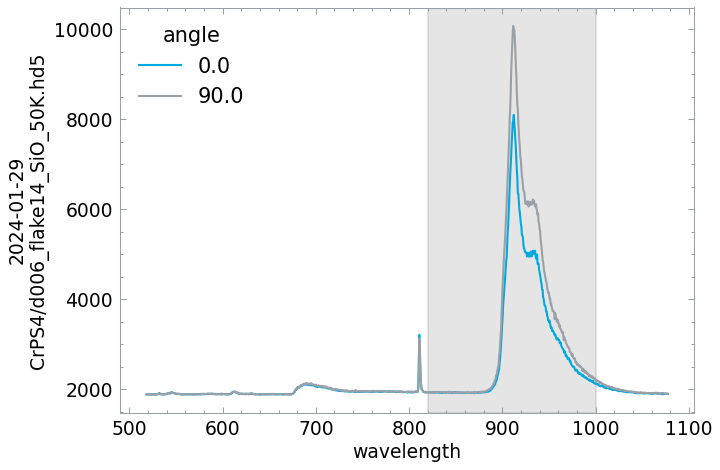

In [21]:
plt.figure()
sel = [d for d in data if "300K" in d.name][0]
sel = data[-1]
sel.isel(angle=[0, -1]).plot.line(hue="angle")
plt.axvspan(820, 1000, alpha=0.2, color="grey")
plt.show()

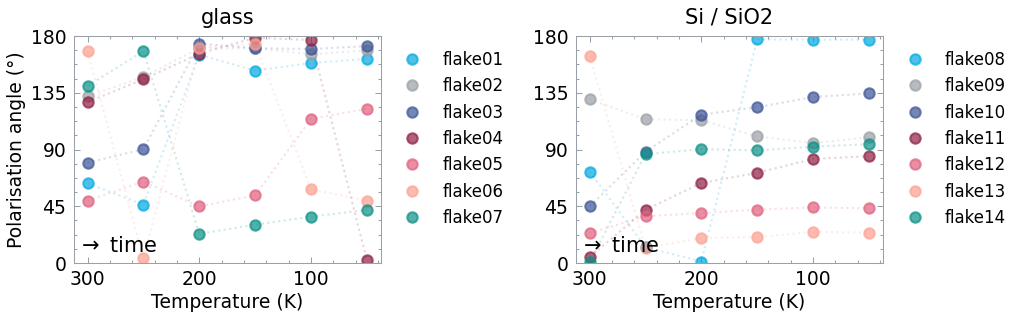

In [55]:
from sklearn.linear_model import HuberRegressor, LinearRegression

def polarisation_model(x, a,b,c):  return a* np.cos(x*np.pi/180) + b* np.sin(x*np.pi/180) + c
def polarisation_fit(angle, values, linear_drift=True):
    reg = HuberRegressor()
    # reg = LinearRegression()
    x = np.cos(angle*np.pi/180*2)   # 2x angle because of the cos^2
    y = np.sin(angle*np.pi/180*2)   # 2x angle because of the cos^2
    if linear_drift:
        z = np.arange(len(angle))   # linear drift
        X = np.column_stack((x, y, z))
    else:
        X = np.column_stack((x, y,))
    reg.fit(X, values)
    (a,b), c = reg.coef_[:2], reg.intercept_
    return (a,b,c), reg
def polarisation_lin(angle, values):
    (a,b,c), reg = polarisation_fit(angle, values)
    angle = np.arctan2(b,a) * 180 / np.pi
    angle = angle/2 # because of the cos^2
    angle = angle % 180
    degree = np.sqrt(a**2 + b**2) / c
    return degree, angle, reg

# def pre(d): return d.sel(wavelength=slice(820, 1000)).rolling(wavelength=50).mean().max("wavelength")
def pre(d): return d.sel(wavelength=slice(820, 1000)).mean("wavelength")

def get_polarisation(d):
    sel = pre(d)
    degree, angle, _ = polarisation_lin(sel.angle*2, sel)    
    # angle += 180-7
    # angle = angle % 180
    return degree, angle

groups = list(groupby_list(data, lambda d: d.attrs["flake"]).items())

fit_data = [(k,  np.array([[d.temperature, *get_polarisation(d)] for d in v]).T) for k,v in groups]

plt.figure(figsize=FIGSIZE_WIDE)
for i, sel in enumerate([fit_data[0:7], fit_data[7:]]):
    plt.subplot(1,2,i+1)
    plt.title(["glass", "Si / SiO2"][i])
    for i,(k,v) in enumerate(sel):
        mk = plt.plot(v[0], v[2], "o", ms=5, label=k, alpha=.7)
        plt.plot(v[0], v[2], linestyle="dotted", color=mk[0].get_color(), alpha=.2)
    plt.legend(fontsize=FONTSIZE_TINY, bbox_to_anchor=(1.0,1.0))
    plt.gca().invert_xaxis()
    plt.ylim(0, 180)
    plt.yticks(np.arange(0, 181, 45))
    plt.text(0.01, 0.05, r"$\rightarrow$ time",transform=plt.gca().transAxes)
    plt.xlabel("Temperature (K)")

plt.gcf().axes[0].set_ylabel("Polarisation angle (°)")
# plt.savefig("../report/figures/2024-01-29 rotating pl.pdf")
plt.show()


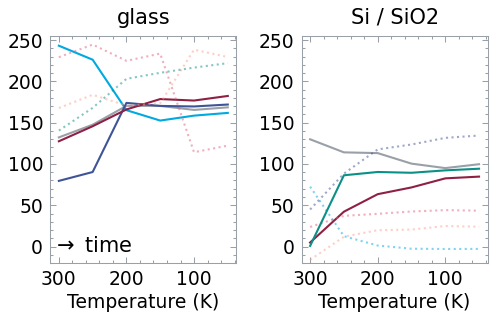

In [58]:
def warp(a, center=90):
    return (a - center + 90) % 180 - 90 + center

plt.figure(figsize=FIGSIZE_MEDIUM)
ax = None
for i, (sel, center, not_aligning) in enumerate(zip(
        [fit_data[0:7], fit_data[7:]], 
        [160, 50], 
        [[4, 5, 6], [0, 2, 4, 5]]
    )):
    ax = plt.subplot(1,2,i+1, sharey=ax)
    plt.title(["glass", "Si / SiO2"][i])
    for j,(k,v) in enumerate(sel):
        a = v[2]
        a = warp(a, center=center)
        # mk = plt.plot(v[0], v[2], "o", ms=5, label=k, alpha=.7)
        # plt.plot(v[0], v[2], linestyle="dotted", color=mk[0].get_color(), alpha=.2)
        if j not in not_aligning:
            plt.plot(v[0], a, "-", label=k)
        else:
            plt.plot(v[0], a, linestyle="dotted", label=k, alpha=.5)
    # plt.legend(fontsize=FONTSIZE_TINY, bbox_to_anchor=(1.0,1.0))
    plt.gca().invert_xaxis()
    # plt.ylim(0, 180)
    # plt.yticks(np.arange(0, 181, 45))
    if i==0:
        plt.text(0.01, 0.05, r"$\rightarrow$ time",transform=plt.gca().transAxes)
    plt.xlabel("Temperature (K)")

plt.ylim(-20, 255)
# plt.gcf().axes[0].set_ylabel("Polarisation angle (°)")
plt.savefig("../report/figures/2024-01-29 rotating pl.pdf")
plt.show()

AttributeError: 'list' object has no attribute 'items'

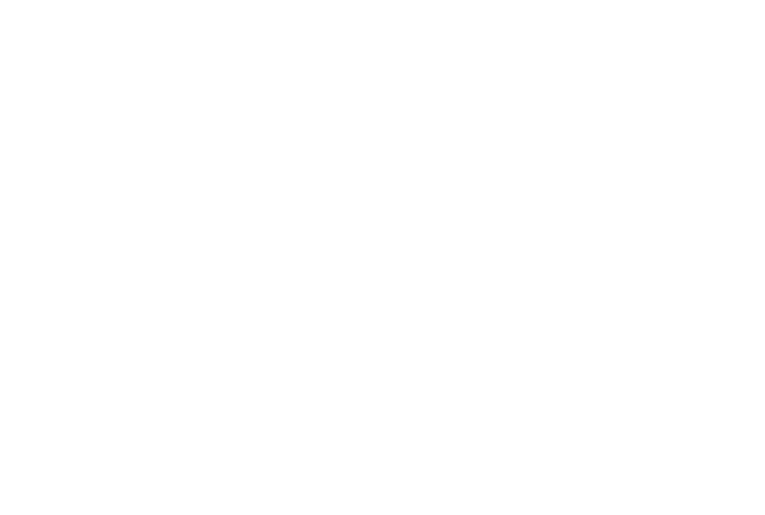

In [23]:
def warp(a):
    center = 120
    return (a - center + 90) % 180 - 90 + center

plt.figure()
for k,v in fit_data.items():
    a = v[1]
    a = warp(a)
    plt.plot(v[0], a, "-", label=k)
plt.legend(fontsize=FONTSIZE_TINY, frameon=True)
plt.gca().invert_xaxis()
# plt.ylim(0, 180)
# plt.yticks(np.arange(0, 361, 45))
plt.text(0.01, 0.05, r"$\rightarrow$ time",transform=plt.gca().transAxes)
plt.xlabel("Temperature (K)")
plt.ylabel("Polarisation angle (°)")
plt.savefig("../report/figures/2024-01-23 rotating pl.pdf")
plt.show()

## Images

In [59]:
paths = glob("../data/2024-01-29*/*.bmp")

def import_image(p):
    img = xr.DataArray(mpl.image.imread(p), dims=["y", "x", "channel"])
    img.name = p
    img.attrs = {
        "flake": "flake" + p.split("flake")[-1].split("_")[0],
        "temperature": int(p.split("K")[0].split("_")[-1]),
    }
    return img

images = [import_image(p) for p in paths if "spot" not in p]

In [ ]:
[[4, 5, 6], [0, 2, 4, 5]]

In [ ]:
[5, 6, 7, 8, 10, 12, 14]

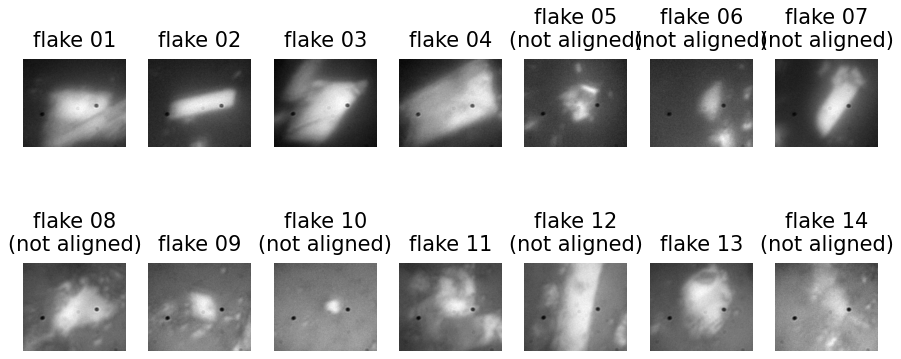

In [67]:
def cropp_image(image):
    cropped = image.sel(x=slice(800, 1150), y=slice(450, 750)).mean("channel")
    cropped.attrs = image.attrs
    return cropped

cropped_images = [cropp_image(i) for i in images]

groups_images = list(groupby_list(cropped_images, lambda d: d.attrs["flake"]).items())

# create previews of all flakes
fig, axs = plt.subplots(2,len(groups_images)//2, sharex=True, sharey=True, figsize=FIGSIZE_HUGE)

def normalize(img):
    img = img - img.min()
    img = img / img.max()
    return img

not_aligned = [5, 6, 7, 8, 10, 12, 14]

for ax, (g, imgs) in zip(axs.flatten(), groups_images):
    ax.imshow(normalize(imgs[-1]), cmap="gray")
    # ax.imshow(edge(imgs[-1]), cmap="gray")
    ax.axis("off")
    # ax.plot([0,1], [.5,.5], color="red", transform=ax.transAxes, alpha=.2)
    # ax.plot([.5,.5], [0,1], color="red", transform=ax.transAxes, alpha=.2)
    if int(g.split("flake")[-1]) in not_aligned:
        ax.set_title(g.replace("flake", "flake ") + "\n(not aligned)")
    else:
        ax.set_title(g.replace("flake", "flake "))
    
    
plt.savefig("../report/figures/2024-01-29 flakes.pdf", bbox_inches="tight")
plt.show()